# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель проекта** - построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
# импорт необходимых библиотек и инструментов

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# загрузка датафрейма

df = pd.read_csv('/datasets/faces/labels.csv') 
display(df.head())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
# анализ данных возраста

df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


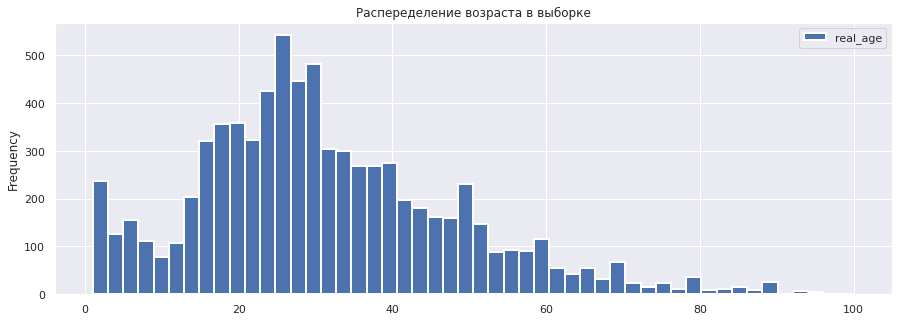

In [4]:
# построение распредления возраста

sns.set_theme(style="darkgrid")
df['real_age'].plot(kind='hist',
                    bins=50,
                    linewidth=2, 
                    grid=True, 
                    legend=True, 
                    title='Распределение возраста в выборке',
                    figsize=(15,5))
plt.show()

In [5]:
# загрузка изображений

train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

In [6]:
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345)

Found 5694 validated image filenames.


In [7]:
features, target = next(train_datagen_flow)

In [8]:
# анализ признаков

print(features.shape)

(32, 224, 224, 3)


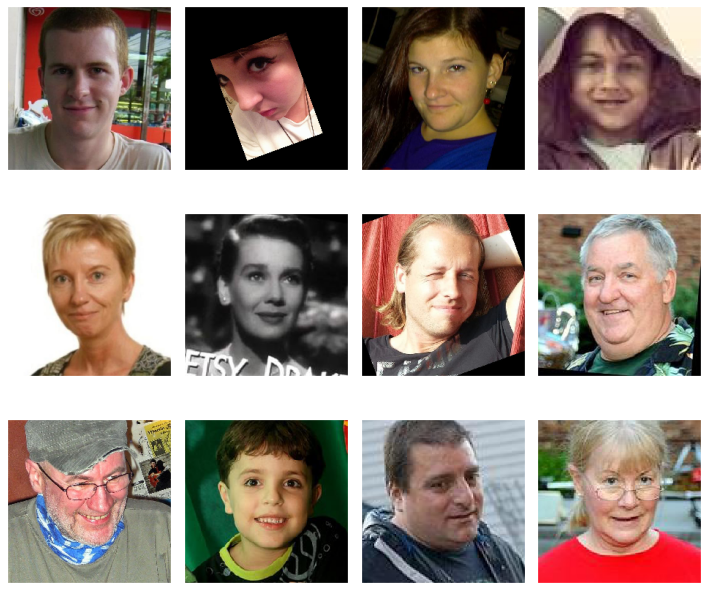

In [9]:
# вывод на экран 12ти фотографий

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

- Датасет содержит 7591 строку с фотографией человека и его возрастом, что является достаточно большим объемом данных для эффективного обучения модели;
- Возраст в выборке варьируются от 1 года до 100 лет, в данных нет выбросов;
- Больше всего представлено людей в возрасте от 20 до 30 лет;
- В признаках — четырёхмерный тензор, в котором 32 изображения размером 224x224 с тремя цветовыми каналами.

## Обучение модели

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(path + 'labels.csv'),
    x_col='file_name',
    y_col='real_age',
    directory=path+'final_files',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345)
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(path + 'labels.csv'),
    directory=path+'final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)
    return test_datagen_flow
    
def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model 

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 73s - loss: 235.5344 - mae: 11.1067 - val_loss: 893.1891 - val_mae: 25.0329
Epoch 2/10
178/178 - 40s - loss: 61.8030 - mae: 5.9547 - val_loss: 812.5634 - val_mae: 23.5248
Epoch 3/10
178/178 - 40s - loss: 30.1940 - mae: 4.2357 - val_loss: 321.9228 - val_mae: 13.1508
Epoch 4/10
178/178 - 40s - loss: 18.4065 - mae: 3.2802 - val_loss: 148.1237 - val_mae: 9.0764
Epoch 5/10
178/178 - 40s - loss: 14.2803 - mae: 2.9186 - val_loss: 84.6503 - val_mae: 6.9106
Epoch 6/10
178/178 - 40s - loss: 11.1501 - mae: 2.6005 - val_loss: 77.3156 - val_mae: 6.8846
Epoch 7/10
178/178 - 40s - loss: 8.9840 - mae: 2.2795 - val_loss: 63.8167 - val_mae: 6.0405
Epoch 8/10
178/178 - 40s - loss: 8.4987 - mae: 2.2100 - val_loss: 65.0119 - val_mae: 6.1204
Epoch 9/10
178/178 - 41s - loss: 7.6204 - mae: 2.1069 - val_loss: 65.6287 - val_mae: 6.1695
Epoch 10/10
178/178 - 42s - loss: 7.6499 - mae: 2.0722 - val_loss: 67.6918 - val_mae: 6.2300

60/60 - 11s - loss: 67.6918 - mae: 6.2300
Test MAE: 6.2300

```

## Анализ обученной модели

- Для обучения модели была использована архитектура ResNet50, обученная на ImageNet. ResNet была адаптирована к данной задаче путем удаления дефолтной "верхушки" и добавления отдельных двух слоёв. Последний выходной полносвязный слой имеет один нейтрон с активацией ReLu.
- При обучении нейронной сети были использованы параметры: learning_rate=0.0001, функция потерь - `mse`, метрика качества - `mae`, количество эпох - 10.
- Средняя абсолютная ошибка у построенной модели получилась 6.23, что подходит под условие задачи "mae не выше 8". Таким образом, задача проекта выполнена.